In [94]:
# M=[0xFFFFFFFF, 0x4BA5A933, 0x7D910E5A, 0x6D26339C, 0x71C7C3E0, 0x7E0FFC00, 0x731D8E64, 0x6B44F5B0, 0x7DC218EC, 0x4DA1B746, 0x42F0FFFF]
M = [4294967295, 1269147955, 2106658394, 1831220124, 1908917216, 2114976768, 1931316836, 1799681456, 2109872364, 1302443846, 1123090431]

# K=11 bit, S=14 symbols
C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
cw_QPSK = zeros(Complex{Float64}, 16)
cw = zeros(Complex{Float64}, 32);


In [95]:
function generate_d_sequence(C)
    D = mod(C, 2) * M[1]
    
    for n in 2:11
        D = xor(D, Int(mod(floor(C * 2.0^(1-n)), 2) * M[n]))  # Convert result to Int
    end
    
    return D
end

generate_d_sequence (generic function with 1 method)

In [96]:
# Example usage
C_value = 123  # Replace with your desired value for C
D = generate_d_sequence(C_value)
println(D)

2779370708


In [97]:
function generate_cw_sequence(C)
    cw_QPSK = zeros(ComplexF64, 16, 1)
    cw = zeros(32, 1)

    D = M[1] * mod(C, 2)

    for n = 2:11
        D = xor(D, Int(mod(floor(C * (2.0^(1-n))), 2) * M[n]))
    end

    idx = 0
    for n = 0:2:31
        bit0 = 1 - 2 * Int(mod(floor(D / 2.0^n), 2))
        bit1 = 1 - 2 * Int(mod(floor(D / 2.0^(n+1)), 2))
        cw[1 + n] = bit0
        cw[2 + n] = bit1  # Remove the pi/2 rotation to use normal BPSK
        cw_QPSK[1 + div(n, 2)] = (Float64(bit0) + im * Float64(bit1)) / sqrt(2)
    end

    return cw, cw_QPSK
end

generate_cw_sequence (generic function with 1 method)

In [98]:
cw_result, cw_QPSK_result = generate_cw_sequence(D)

println("CW Sequence: ", cw_result)
println("CW QPSK Sequence: ", cw_QPSK_result)


CW Sequence: [-1.0; 1.0; 1.0; 1.0; -1.0; 1.0; 1.0; -1.0; -1.0; 1.0; 1.0; -1.0; 1.0; 1.0; -1.0; 1.0; -1.0; -1.0; -1.0; -1.0; -1.0; -1.0; -1.0; -1.0; 1.0; -1.0; -1.0; 1.0; -1.0; 1.0; -1.0; 1.0;;]
CW QPSK Sequence: ComplexF64[-0.7071067811865475 + 0.7071067811865475im; 0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 - 0.7071067811865475im; 0.7071067811865475 - 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im; -0.7071067811865475 + 0.7071067811865475im;;]


In [99]:
function rate_matching(C, cw, cw_QPSK, C11_3gpp, C11_3gpp_QPSK)
    idx = 0
    for symb in 0:13
        for re in 0:11
            if symb == 3 || symb == 10
                C11_3gpp[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
                C11_3gpp_QPSK[1 + C, 1 + (symb * 12) .+ (0:11)] .= ones(12)  # Adjusted broadcasting
                symb += 1
            end
            C11_3gpp[1 + C, 1 + (symb * 12) + re] = cw[1 + rem(idx, 32)]  # rate-matching of the cw-sequence
            C11_3gpp_QPSK[1 + C, 1 + (symb * 12) + re] = cw_QPSK[1 + rem(idx, 16)]  # rate-matching of the cw-sequence
            idx += 1
        end
    end
end


rate_matching (generic function with 1 method)

In [100]:
# C is the code sequence to be generated
C=77;
c0_t = zeros(Complex{Float64}, 2048, 14 * 12)
c0_t_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)
C11_3gpp = zeros(Complex{Float64}, 2048, 14 * 12)
C11_3gpp_QPSK = zeros(Complex{Float64}, 2048, 14 * 12)
cw_QPSK = zeros(Complex{Float64}, 16)
cw = zeros(Complex{Float64}, 32);

rate_matching(C, cw, cw_QPSK, C11_3gpp, C11_3gpp_QPSK)


In [101]:
using FFTW

In [102]:
function generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK)
    c0_t = []
    c0_t_QPSK = []

    for symb in 0:13
        # extract OFDM symbols "symb" from the coded sequence and perform DFT-precoding (SC-FDMA)
        if symb == 3
            symb = 4
        end
        if symb == 10
            symb = 11
        end

        c0_f = fft(C11_3gpp[1 + C, 1 + symb * 12 : 1 + symb * 12 + 11])
        c0_f_QPSK = fft(C11_3gpp_QPSK[1 + C, 1 + symb * 12 : 1 + symb * 12 + 11])

        # Use the entire array with ifft and then extract real and imaginary parts
        push!(c0_t, real(ifft(c0_f)))
        push!(c0_t_QPSK, real(ifft(c0_f_QPSK)))
    end

    # Reshape arrays if needed
    c0_t = hcat(c0_t...)
    c0_t_QPSK = hcat(c0_t_QPSK...)

    return c0_t, c0_t_QPSK
end


generate_c0_t (generic function with 2 methods)

In [103]:
C = 77
c0_t, c0_t_QPSK = generate_c0_t(C, C11_3gpp, C11_3gpp_QPSK)


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [104]:
using Plots

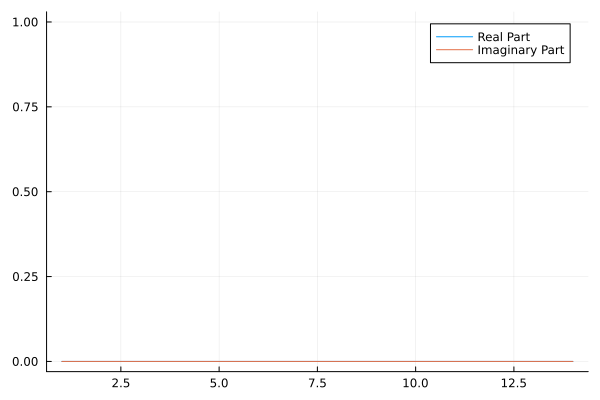

In [105]:
# Figure 1
plot(real(c0_t[1, :]), label="Real Part")
plot!(imag(c0_t[1, :]), label="Imaginary Part")

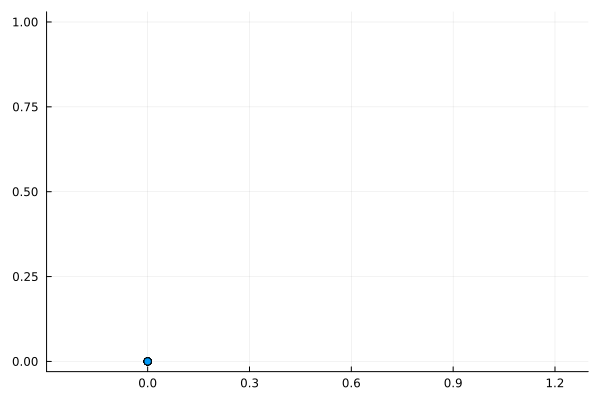

In [106]:
# Figure 2
plot(real(c0_t[1, :]), imag(c0_t[1, :]), seriestype=:scatter, label="", aspect_ratio=:equal)

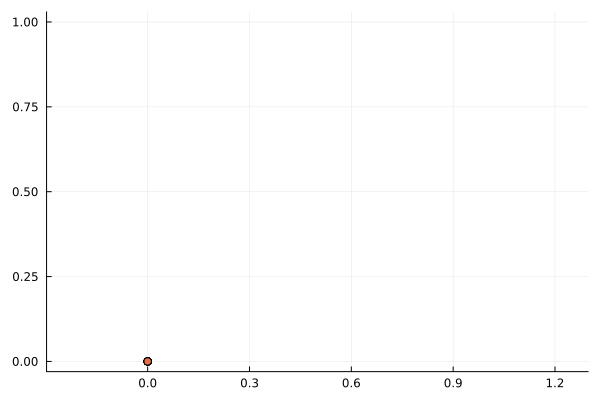

In [107]:
# Figure 3
plot!(real(c0_t_QPSK[1, :]), imag(c0_t_QPSK[1, :]), seriestype=:scatter, label="", aspect_ratio=:equal)